In [1]:
import matplotlib.pyplot as plt 
%load_ext autoreload
%autoreload 2

In [2]:
from velotest.hypothesis_testing import run_hypothesis_test_on
from velotest.plotting import arrow_plot, marker_plot
import scvelo
import matplotlib.pyplot as plt

In [3]:
adata = scvelo.datasets.pancreas()
scvelo.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scvelo.pp.moments(adata, n_pcs=30, n_neighbors=30)

# Compute velocity
scvelo.tl.velocity(adata)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/Users/pavlin/Dev/scvelo/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/var/folders/fd/4_c2gbtj6sx1y6bwq7v_sfmw0000gn/T/ipykernel_17704/3862235610.py:3: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scvelo.pp.moments(adata, n_pcs=30, n_neighbors=30)
/Users/pavlin/Dev/scvelo/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/Users/pavlin/Dev/scvelo/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


## Velocity projection methods

### scvelo

In [4]:
adata_scvelo = adata.copy()

computing velocity graph (using 1/10 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.

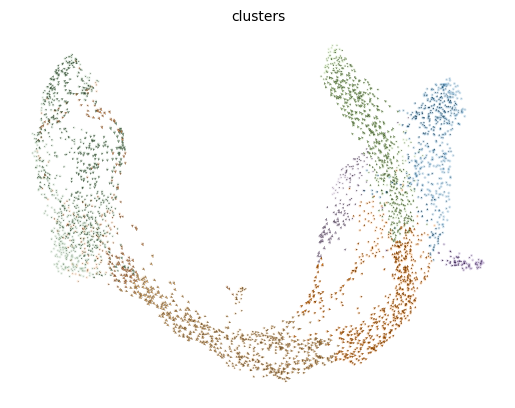

In [5]:
# Compute 2D embedding of velocity vectors
scvelo.tl.velocity_graph(adata_scvelo)
scvelo.pl.velocity_embedding(adata_scvelo)

In [6]:
adata.obsm["velocity_scvelo"] = adata_scvelo.obsm["velocity_umap"].copy()

In [7]:
# Run test
uncorrected_p_values, h0_rejected, debug_dict = run_hypothesis_test_on(
    adata,
    basis="umap",
    velocity_basis="velocity_scvelo",
    number_neighbors_to_sample_from=300,
    number_neighborhoods=500,
    null_distribution="velocities",
    cosine_empty_neighborhood=None,
    correction="bonferroni",
    restrict_to_velocity_genes=True,
)

Dropping all the genes which are not velocity genes. 1038 genes left.


100%|████████████████████████████████████████████████████████████████████████████████| 693/693 [02:53<00:00,  4.00it/s]


<Axes: >

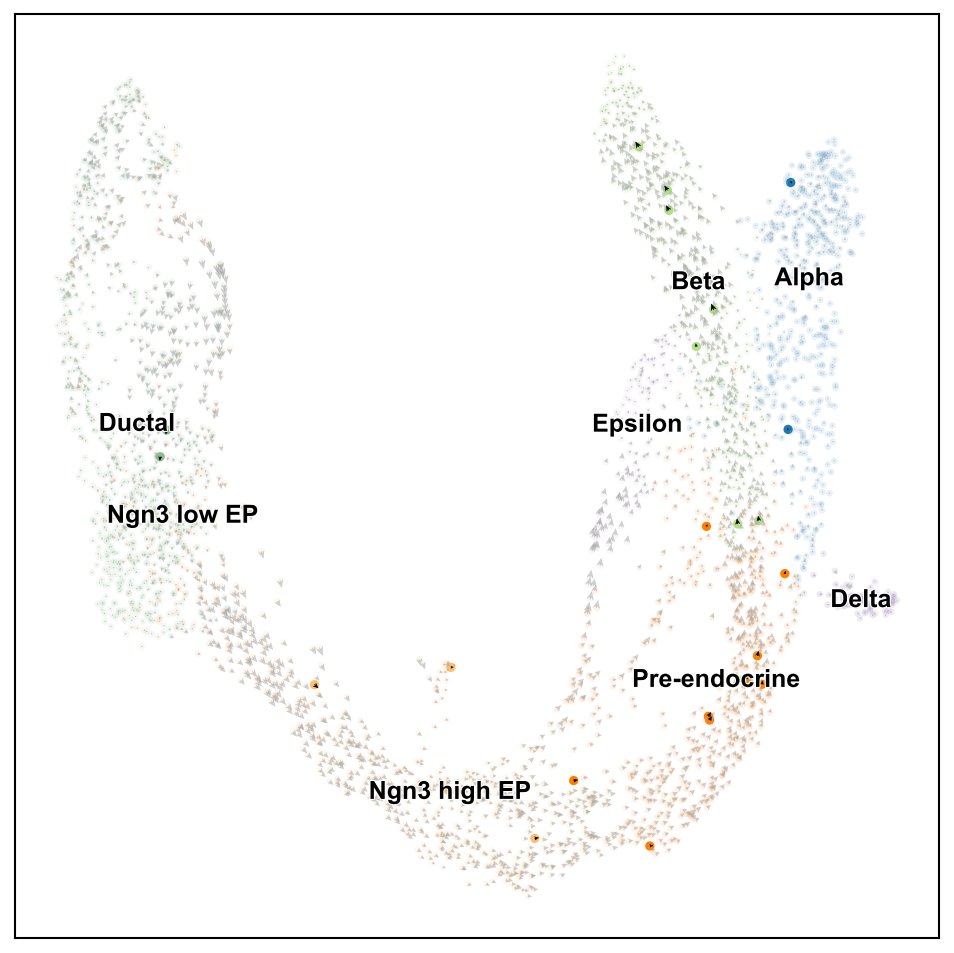

In [34]:
import matplotlib as mpl
mpl.rc_file("../matplotlibrc-embeddings")

color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
labels = adata.obs["clusters"]

arrow_plot(adata.obsm['X_umap'], adata.obsm['X_umap'] + adata.obsm['velocity_scvelo'], uncorrected_p_values, h0_rejected, labels=labels, label_colormap=color_dict)

### Nystroem

In [9]:
adata_nystroem = adata.copy()

In [10]:
import velocity as nystroem

In [11]:
nystroem.project.pca.pca_project(adata_nystroem)
nystroem.project.nystroem.nystroem_project(adata_nystroem, basis="umap")

Variance and mean stabilisation of count matrix for PCA.
Calculating PCA.
Projecting future states.
Saving to annData object.
Scaling velocities down, set "force_no_scale=True" to stop this.
Projecting velocities using Nyström approach.
Saving to annData object.


In [12]:
adata_nystroem

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_scvelo', 'velocity_pca', 'velocity_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [13]:
adata.obsm["velocity_nystroem"] = adata_nystroem.obsm["velocity_umap"].copy()
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_scvelo', 'velocity_nystroem'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [35]:
# Run test
uncorrected_p_values, h0_rejected, debug_dict = run_hypothesis_test_on(
    adata,
    basis="umap",
    velocity_basis="velocity_nystroem",
    number_neighbors_to_sample_from=300,
    number_neighborhoods=500,
    null_distribution="velocities",
    cosine_empty_neighborhood=None,
    correction="bonferroni",
    restrict_to_velocity_genes=True,
)

Dropping all the genes which are not velocity genes. 1038 genes left.


100%|████████████████████████████████████████████████████████████████████████████████| 695/695 [02:57<00:00,  3.91it/s]


<Axes: >

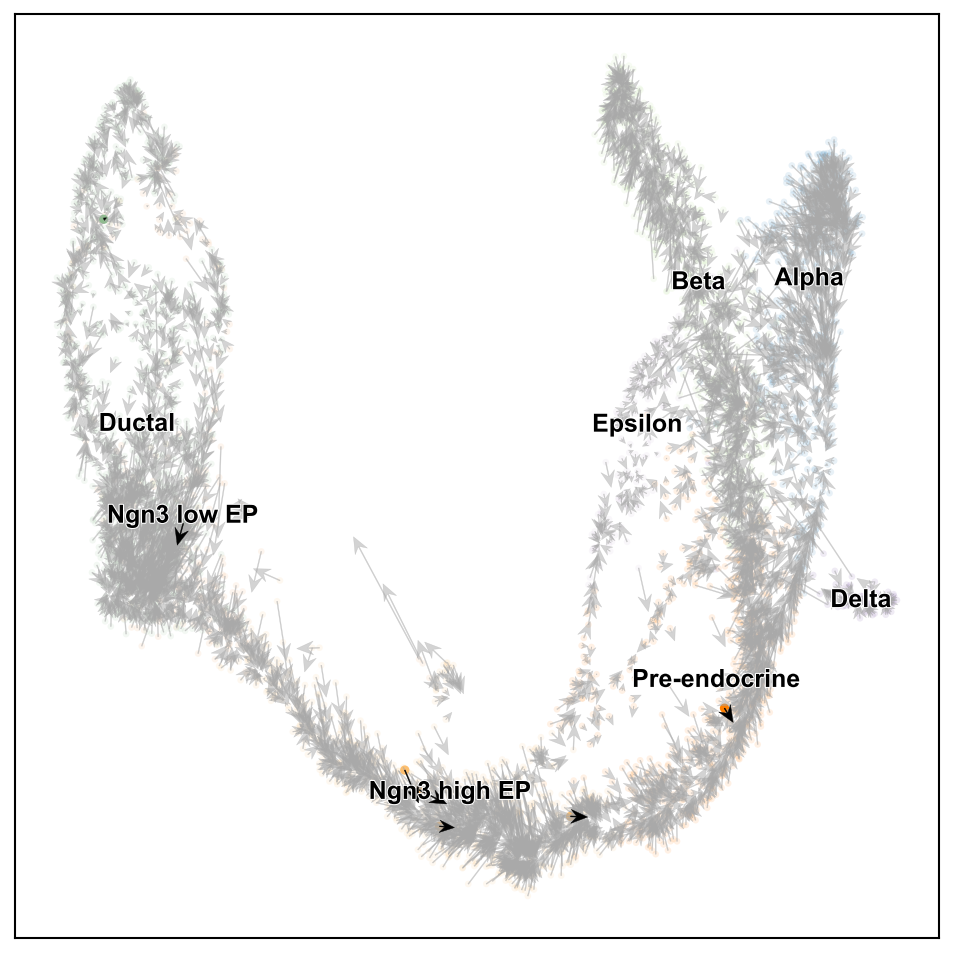

In [36]:
import matplotlib as mpl
mpl.rc_file("../matplotlibrc-embeddings")

color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
labels = adata.obs["clusters"]

arrow_plot(adata.obsm['X_umap'], adata.obsm['X_umap'] + adata.obsm['velocity_nystroem'], uncorrected_p_values, h0_rejected, labels=labels, label_colormap=color_dict)

### Veloviz

In [15]:
def convert_named_list(d):
    return {str(item.name): item.value for item in d.items()}

In [16]:
adata_veloviz = adata.copy()

In [17]:
x = adata.layers["Ms"]
xv = x + adata.layers["velocity"]
x.shape, xv.shape

((3696, 2000), (3696, 2000))

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20, random_state=0)
x_pca = pca.fit_transform(x)
xv_pca = pca.transform(xv)

x_pca.shape, xv_pca.shape

((3696, 20), (3696, 20))

In [19]:
from rpy2.robjects import r, globalenv
import rpy2.robjects.numpy2ri
from rpy2.robjects.conversion import localconverter

with localconverter(rpy2.robjects.numpy2ri.converter):
    r("library(veloviz)")
    
    globalenv["x"] = x_pca
    globalenv["xv"] = xv_pca
    globalenv["x_cells"] = adata.obs_names.tolist()
    
    r("rownames(x) = x_cells")
    r("rownames(xv) = x_cells")
    
    r("x = t(x)")
    r("xv = t(xv)")
    
    result = r("buildVeloviz(x, xv, normalize.depth=F, use.ods.genes=F, pca=F, k=10, w=1)")

Error importing in API mode: ImportError("dlopen(/Users/pavlin/miniconda3/envs/velocity/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <733B2185-C608-342F-8FC5-CF619524A0A2> /Users/pavlin/miniconda3/envs/velocity/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


[1] "Done finding neighbors"
[1] "calculating weights"
[1] "Done making graph"


In [20]:
result_dict = convert_named_list(result)
result_dict["projected_neighbors"] = convert_named_list(result_dict["projected_neighbors"])
result_dict.keys()

dict_keys(['graph', 'fdg_coords', 'projected_neighbors'])

In [21]:
adata_veloviz.obsm["X_veloviz"] = result_dict["fdg_coords"]
adata.obsm["X_veloviz"] = result_dict["fdg_coords"]

In [22]:
scvelo.tl.velocity_graph(adata_veloviz)

computing velocity graph (using 1/10 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_veloviz', embedded velocity vectors (adata.obsm)


/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.

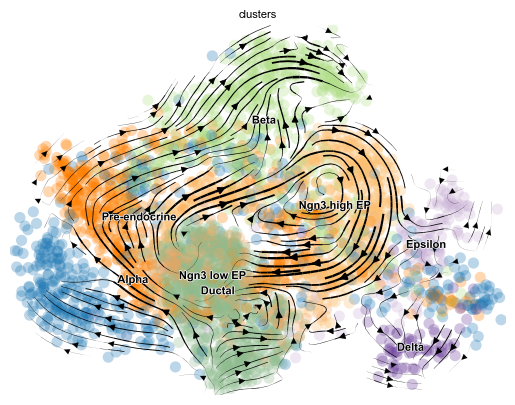

In [23]:
scvelo.pl.velocity_embedding_stream(adata_veloviz, basis="veloviz")

In [24]:
adata.obsm["velocity_veloviz"] = adata_veloviz.obsm["velocity_veloviz"]

In [37]:
# Run test
uncorrected_p_values, h0_rejected, debug_dict = run_hypothesis_test_on(
    adata,
    basis="veloviz",
    velocity_basis="velocity_veloviz",
    number_neighbors_to_sample_from=300,
    number_neighborhoods=500,
    null_distribution="velocities",
    cosine_empty_neighborhood=None,
    correction="bonferroni",
    restrict_to_velocity_genes=True,
)

Dropping all the genes which are not velocity genes. 1038 genes left.


100%|████████████████████████████████████████████████████████████████████████████████| 692/692 [03:00<00:00,  3.84it/s]


<Axes: >

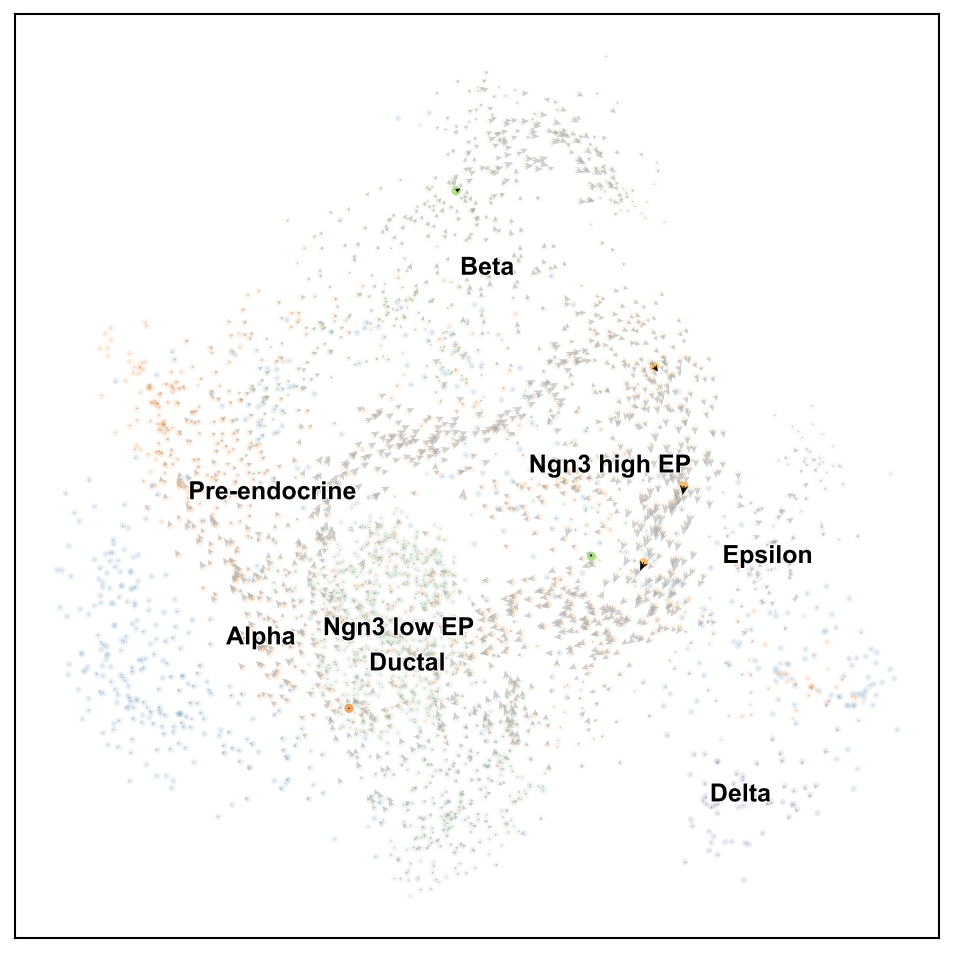

In [38]:
import matplotlib as mpl
mpl.rc_file("../matplotlibrc-embeddings")

color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
labels = adata.obs["clusters"]

arrow_plot(adata.obsm['X_veloviz'], adata.obsm['X_veloviz'] + adata.obsm['velocity_veloviz'], uncorrected_p_values, h0_rejected, labels=labels, label_colormap=color_dict)

### Veloviz -- Python

In [43]:
adata_veloviz2 = adata.copy()

In [44]:
import veloviz
veloviz.__file__

'/Users/pavlin/Papers/2025/velocity-hypothesis-test/notebooks/veloviz.py'

In [45]:
veloviz_graph = veloviz.veloviz(x, xv, pca_components=20)
veloviz_graph

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 36912 stored elements and shape (3696, 3696)>

In [46]:
x_veloviz = veloviz.fr_layout_igraph(veloviz_graph)
x_veloviz.shape

(3696, 2)

In [47]:
adata_veloviz2.obsm["X_veloviz"] = x_veloviz

computing velocity graph (using 1/10 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_veloviz', embedded velocity vectors (adata.obsm)


/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.

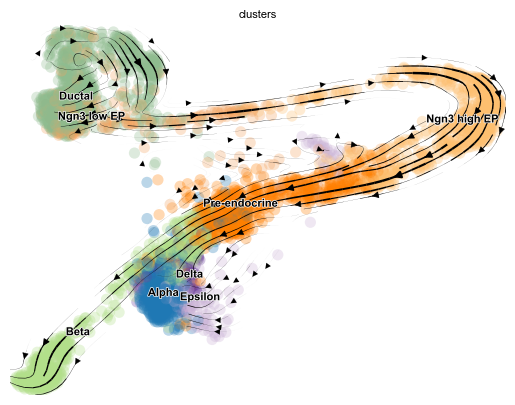

In [48]:
scvelo.tl.velocity_graph(adata_veloviz2)
scvelo.pl.velocity_embedding_stream(adata_veloviz2, basis="veloviz")

In [49]:
adata.obsm["X_veloviz2"] = x_veloviz
adata.obsm["velocity_veloviz2"] = adata_veloviz.obsm["velocity_veloviz"]

In [50]:
# Run test
uncorrected_p_values, h0_rejected, debug_dict = run_hypothesis_test_on(
    adata,
    basis="veloviz2",
    velocity_basis="velocity_veloviz2",
    number_neighbors_to_sample_from=300,
    number_neighborhoods=500,
    null_distribution="velocities",
    cosine_empty_neighborhood=None,
    correction="bonferroni",
    restrict_to_velocity_genes=True,
)

Dropping all the genes which are not velocity genes. 1038 genes left.


100%|████████████████████████████████████████████████████████████████████████████████| 660/660 [02:44<00:00,  4.01it/s]


<Axes: >

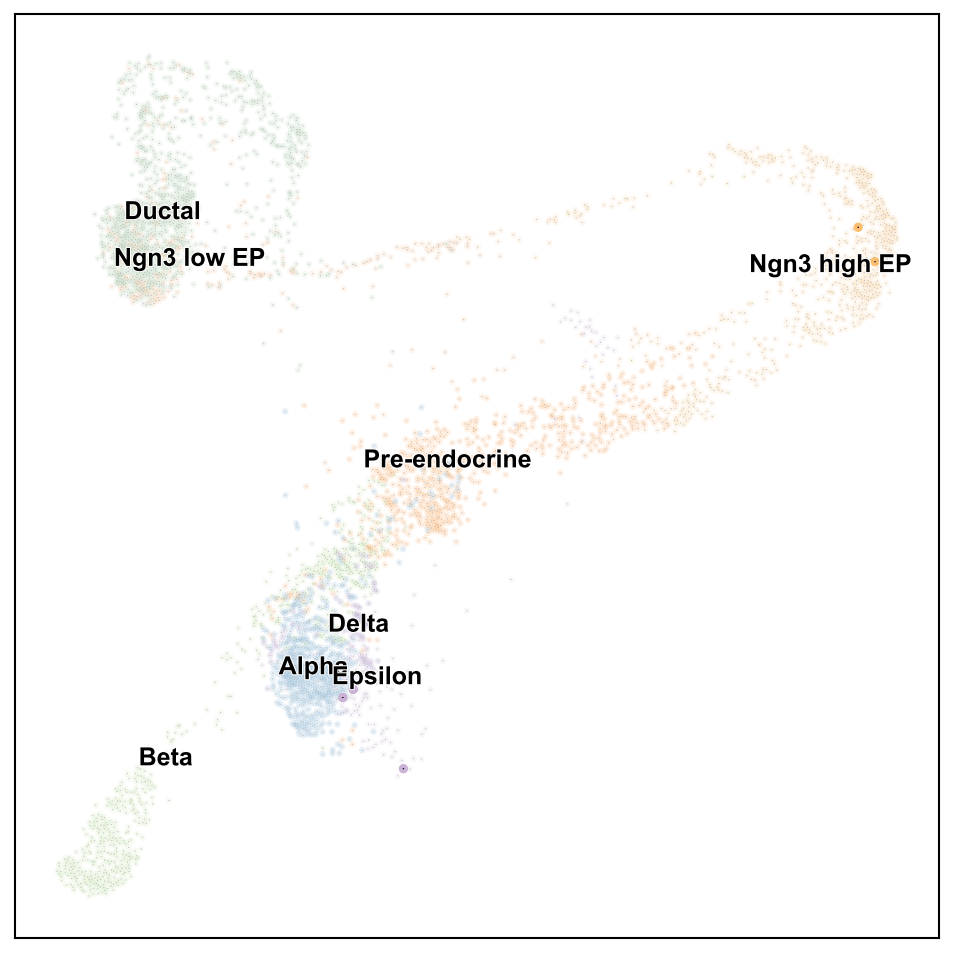

In [51]:
import matplotlib as mpl
mpl.rc_file("../matplotlibrc-embeddings")

color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
labels = adata.obs["clusters"]

arrow_plot(adata.obsm['X_veloviz2'], adata.obsm['X_veloviz2'] + adata.obsm['velocity_veloviz2'], uncorrected_p_values, h0_rejected, labels=labels, label_colormap=color_dict)

### Save anndata

In [52]:
adata.write_h5ad("pancreas.h5ad")

## Plotting